In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# ML Training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

# ML Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix

### Handling Data ###

In [2]:
# Import expression data
expression = pd.read_csv('data/Gene_expression_log2.csv')
expression.head()

,patient_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,...,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,sample_type
0,TCGA-05-4244,0.0,3.460913,3.618474,5.661048,9.731217,0.0,8.435591,1.033652,0.000000,...,9.018679,5.350285,8.197320,9.907260,0.763921,10.088854,11.471137,9.768648,9.170596,1
1,TCGA-05-4249,0.0,3.034867,3.748848,6.515884,9.853335,0.0,7.191819,1.383939,0.000000,...,8.172463,5.980428,8.950002,10.204975,4.411650,9.622978,11.199826,10.153704,9.433116,1
2,TCGA-05-4250,0.0,3.043572,2.811142,5.659257,10.156943,0.0,5.720508,0.000000,0.000000,...,10.033203,5.931168,8.517335,9.722642,4.782796,8.895339,12.408980,10.194166,9.060342,1
3,TCGA-05-4382,0.0,3.624230,3.099968,6.389400,9.658520,0.0,7.913021,0.564232,0.309525,...,9.558593,5.373036,8.441915,9.888267,6.041142,9.828389,12.725185,10.192589,9.376842,1
4,TCGA-05-4384,0.0,2.079088,2.168064,6.200361,9.137001,0.0,8.104766,0.687867,0.000000,...,7.275566,6.340285,9.140127,10.368190,3.160501,9.607079,11.706703,10.763478,9.500392,1


## 1 Year

In [5]:
# Import 1-year exp data
yr_one = pd.read_csv('data/top_100_DEgenes_1yr.txt', delimiter='\t')
yr_one.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,GPR77|27202,57.363315,-2.412671,0.229693,-10.503893,8.290000e-26,1.540000e-21
1,MT1A|4489,46.043479,-3.527803,0.431637,-8.173073,3.010000e-16,2.800000e-12
2,SCGB3A1|92304,6620.702084,3.900022,0.486672,8.013647,1.110000e-15,6.920000e-12
3,AMDHD1|144193,31.390227,-2.605383,0.336389,-7.745141,9.550000e-15,4.450000e-11
4,TMEM213|155006,87.078696,3.285105,0.436324,7.529047,5.110000e-14,1.900000e-10


In [6]:
# Number of genes in both datasets
len(set(expression.columns).intersection(set(yr_one.gene)))

100

In [7]:
# How many genes are present in the one-year that aren't in the expression data?
# Should be 0
set(yr_one.gene) - set(expression.columns)

set()

In [8]:
common_genes = set(yr_one.gene).intersection(set(expression.columns))
common_genes.add('patient_id')

In [9]:
yr_one_exp = expression[list(common_genes)]

### Label data ###

Which patients have survived?

In [11]:
y = pd.read_csv('data/labels_3yr.csv')
y.head()

,patient_id,Label
0,TCGA-05-4249,1
1,TCGA-05-4389,1
2,TCGA-05-4390,1
3,TCGA-05-4398,1
4,TCGA-05-4415,0


In [12]:
y.Label.value_counts()

1    119
0     90
Name: Label, dtype: int64

In [13]:
patient_id = y['patient_id']
exp_file = y.merge(yr_one_exp, on='patient_id')
exp_file = exp_file.drop(['patient_id'],axis = 1)

In [14]:
exp_file.shape

(209, 101)

### Add metadata

In [15]:
# Add patient_id back
exp_file['patient_id'] = patient_id

# Add metadata to meta_file
metadata_final = pd.read_csv('data/metadata_final_no_os.csv')
meta_file = metadata_final.merge(exp_file, how='right', on='patient_id')

In [16]:
meta_file

,patient_id,age_at_initial_pathologic_diagnosis,gender_FEMALE,gender_MALE,tumor_stage_Early,tumor_stage_Late,tumor_stage_N/A,is_smoker_False,is_smoker_True,Label,...,NPC1L1|29881,C11orf41|25758,FLG|2312,GNPNAT1|64841,NRN1|51299,OXTR|5021,MS4A15|219995,LOC149620|149620,SNAI2|6591,GRIN2A|2903
0,TCGA-05-4249,67,0,1,1,0,0,0,1,1,...,2.831310,6.816587,3.718822,9.687489,8.034012,5.331945,6.919936,3.276913,6.655446,3.456898
1,TCGA-05-4389,70,0,1,1,0,0,0,1,1,...,3.124014,1.004825,3.265647,10.325171,5.653315,3.124014,3.067398,0.000000,6.089882,0.000000
2,TCGA-05-4390,58,1,0,1,0,0,0,1,1,...,9.635731,9.017710,3.621864,11.682543,10.271685,3.115050,4.084643,0.000000,7.316426,9.554738
3,TCGA-05-4398,47,1,0,0,1,0,0,1,1,...,2.992678,3.569771,3.289185,10.729102,6.555876,5.846651,2.636845,2.825704,6.825786,7.405584
4,TCGA-05-4415,57,0,1,0,1,0,0,1,0,...,3.429991,8.285915,9.265172,11.281095,5.044394,4.643856,3.429991,0.000000,4.564787,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,TCGA-MP-A5C7,76,1,0,1,0,0,0,1,1,...,4.909231,3.749470,1.884871,10.031136,5.366431,3.009831,3.749470,6.160813,5.594184,3.082311
205,TCGA-NJ-A4YF,50,1,0,1,0,0,0,1,1,...,5.382138,2.941651,0.000000,9.968105,5.250185,3.153465,4.695376,0.000000,5.339483,1.497025
206,TCGA-NJ-A4YG,65,0,1,1,0,0,0,1,1,...,3.649305,5.223967,3.195977,9.998506,6.302769,3.776325,7.355950,5.351851,7.376143,2.987030
207,TCGA-NJ-A4YQ,69,1,0,1,0,0,0,1,1,...,3.093053,3.291073,1.232477,8.797068,7.830458,3.093053,6.494096,5.660837,6.969174,1.527671


In [17]:
def format_columns(df):
    '''
    Description: This function aims to format all columns in a given dataset.
                 It removes special characters, replaces spaces with _, \
                 and converts to lowercase.
    Parameters: df, the DataFrame to format.
    '''
    import re
    
    df.columns = [re.sub('[^A-Za-z0-9 _]+', '', c).replace(' ', '_').lower() \
                    for c in df.columns]
    return df

In [18]:
# Make all columns lowercase and regex
meta_file = format_columns(meta_file)

### Permutations of Metadata for Feature Selection

In [19]:
meta_file

,patient_id,age_at_initial_pathologic_diagnosis,gender_female,gender_male,tumor_stage_early,tumor_stage_late,tumor_stage_na,is_smoker_false,is_smoker_true,label,...,npc1l129881,c11orf4125758,flg2312,gnpnat164841,nrn151299,oxtr5021,ms4a15219995,loc149620149620,snai26591,grin2a2903
0,TCGA-05-4249,67,0,1,1,0,0,0,1,1,...,2.831310,6.816587,3.718822,9.687489,8.034012,5.331945,6.919936,3.276913,6.655446,3.456898
1,TCGA-05-4389,70,0,1,1,0,0,0,1,1,...,3.124014,1.004825,3.265647,10.325171,5.653315,3.124014,3.067398,0.000000,6.089882,0.000000
2,TCGA-05-4390,58,1,0,1,0,0,0,1,1,...,9.635731,9.017710,3.621864,11.682543,10.271685,3.115050,4.084643,0.000000,7.316426,9.554738
3,TCGA-05-4398,47,1,0,0,1,0,0,1,1,...,2.992678,3.569771,3.289185,10.729102,6.555876,5.846651,2.636845,2.825704,6.825786,7.405584
4,TCGA-05-4415,57,0,1,0,1,0,0,1,0,...,3.429991,8.285915,9.265172,11.281095,5.044394,4.643856,3.429991,0.000000,4.564787,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,TCGA-MP-A5C7,76,1,0,1,0,0,0,1,1,...,4.909231,3.749470,1.884871,10.031136,5.366431,3.009831,3.749470,6.160813,5.594184,3.082311
205,TCGA-NJ-A4YF,50,1,0,1,0,0,0,1,1,...,5.382138,2.941651,0.000000,9.968105,5.250185,3.153465,4.695376,0.000000,5.339483,1.497025
206,TCGA-NJ-A4YG,65,0,1,1,0,0,0,1,1,...,3.649305,5.223967,3.195977,9.998506,6.302769,3.776325,7.355950,5.351851,7.376143,2.987030
207,TCGA-NJ-A4YQ,69,1,0,1,0,0,0,1,1,...,3.093053,3.291073,1.232477,8.797068,7.830458,3.093053,6.494096,5.660837,6.969174,1.527671


In [20]:
# Grab all metadata features 
label_index = meta_file.columns.get_loc('label')
metadata_features = meta_file.iloc[:,1:label_index]

# Identify top 100 expression data
expression_features = meta_file
y_label = expression_features['label']
expression_features = expression_features.drop(['patient_id','label'], axis=1)

In [21]:
expression_features

,age_at_initial_pathologic_diagnosis,gender_female,gender_male,tumor_stage_early,tumor_stage_late,tumor_stage_na,is_smoker_false,is_smoker_true,has2as594842,hladqb23120,...,npc1l129881,c11orf4125758,flg2312,gnpnat164841,nrn151299,oxtr5021,ms4a15219995,loc149620149620,snai26591,grin2a2903
0,67,0,1,1,0,0,0,1,2.248170,12.885870,...,2.831310,6.816587,3.718822,9.687489,8.034012,5.331945,6.919936,3.276913,6.655446,3.456898
1,70,0,1,1,0,0,0,1,1.591392,10.298887,...,3.124014,1.004825,3.265647,10.325171,5.653315,3.124014,3.067398,0.000000,6.089882,0.000000
2,58,1,0,1,0,0,0,1,3.047556,4.984416,...,9.635731,9.017710,3.621864,11.682543,10.271685,3.115050,4.084643,0.000000,7.316426,9.554738
3,47,1,0,0,1,0,0,1,2.040682,8.547689,...,2.992678,3.569771,3.289185,10.729102,6.555876,5.846651,2.636845,2.825704,6.825786,7.405584
4,57,0,1,0,1,0,0,1,6.911644,4.329920,...,3.429991,8.285915,9.265172,11.281095,5.044394,4.643856,3.429991,0.000000,4.564787,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,76,1,0,1,0,0,0,1,0.500802,7.408517,...,4.909231,3.749470,1.884871,10.031136,5.366431,3.009831,3.749470,6.160813,5.594184,3.082311
205,50,1,0,1,0,0,0,1,1.147372,5.226971,...,5.382138,2.941651,0.000000,9.968105,5.250185,3.153465,4.695376,0.000000,5.339483,1.497025
206,65,0,1,1,0,0,0,1,1.179129,12.701508,...,3.649305,5.223967,3.195977,9.998506,6.302769,3.776325,7.355950,5.351851,7.376143,2.987030
207,69,1,0,1,0,0,0,1,1.213067,8.184970,...,3.093053,3.291073,1.232477,8.797068,7.830458,3.093053,6.494096,5.660837,6.969174,1.527671


### Use XGBoost for Feature Selection

[0.02655808 0.         0.         0.00150447 0.09458521 0.
 0.         0.         0.01050837 0.00281147 0.02658191 0.02845645
 0.00202862 0.01296451 0.02966092 0.00631214 0.00552471 0.00899817
 0.00290594 0.0159386  0.00198051 0.0117862  0.01019723 0.
 0.00428374 0.00066844 0.01402399 0.00347892 0.00524557 0.00989432
 0.00094365 0.00555372 0.00043918 0.03339183 0.01866467 0.01448657
 0.01513385 0.00465182 0.00168542 0.01883448 0.02100622 0.00213587
 0.01407295 0.01110255 0.01062581 0.00783067 0.01179269 0.00050696
 0.00222658 0.05386985 0.00116596 0.         0.00114504 0.00595256
 0.0204591  0.00289558 0.         0.00334007 0.00710347 0.00403839
 0.00364063 0.00651428 0.00447232 0.         0.         0.
 0.00102428 0.01435807 0.0101126  0.00448074 0.01125745 0.00595478
 0.00335119 0.         0.01830338 0.01125996 0.00069126 0.01554918
 0.02747349 0.00670883 0.00861152 0.00206861 0.0058397  0.
 0.01381599 0.01378823 0.         0.00249503 0.00157329 0.
 0.         0.01499157 0.00976009 0

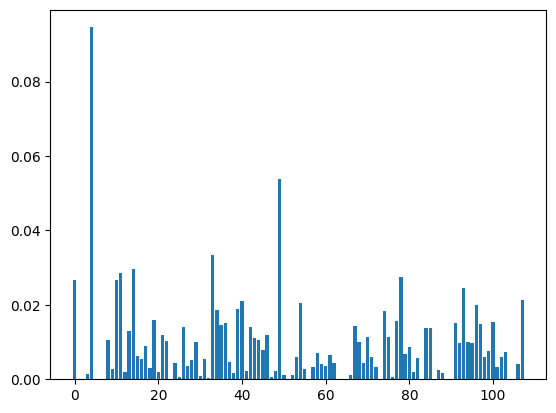

In [22]:
from xgboost import XGBClassifier
from matplotlib import pyplot
from xgboost import plot_importance

# Define dataset as all features
total_features = expression_features
y_label = np.where(y_label == 0, 1, np.where(y_label == 1, 0, y_label))
X_train, X_test, y_train, y_test = train_test_split(total_features, y_label, test_size=0.2, random_state=42)

# fit model
model = XGBClassifier()
model.fit(X_train, y_train)

# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

#### Using feature importances, perform search over various thresholds with XGBoost

In [24]:
model = XGBClassifier()

# Select features using the threshold
selection = SelectFromModel(model).fit(X_train, y_train)

In [25]:
cols = metadata_final.columns.to_list()
cols.extend(expression_features.columns.to_list())
top_features = [c for b, c, in zip(selection.get_support(), cols) if b]
len(top_features)

42

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Thresh=0.000, n=108, F1 Score: 32.26%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Thresh=0.001, n=85, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 1, 'max_depth': 10, 'n_estimators': 50, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Thresh=0.002, n=78, F1 Score: 27.59%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Thresh=0.003, n=70, F1 Score: 40.00%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 1, 'max_depth': 10, 'n_estimators': 10, 'random_sta

C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.035, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.036, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.037, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.038, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.039, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.040, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.041, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.042, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.043, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.044, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.045, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.046, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.047, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.048, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.049, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.050, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.051, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.052, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.053, n=2, F1 Score: 44.44%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 100.0, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Darin Tsui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classificatio

Thresh=0.054, n=1, F1 Score: 30.00%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Thresh=0.055, n=1, F1 Score: 30.00%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Thresh=0.056, n=1, F1 Score: 30.00%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Thresh=0.057, n=1, F1 Score: 30.00%
Best Performer: {'eval_metric': <function f1_score at 0x0000028F80E51430>, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 1

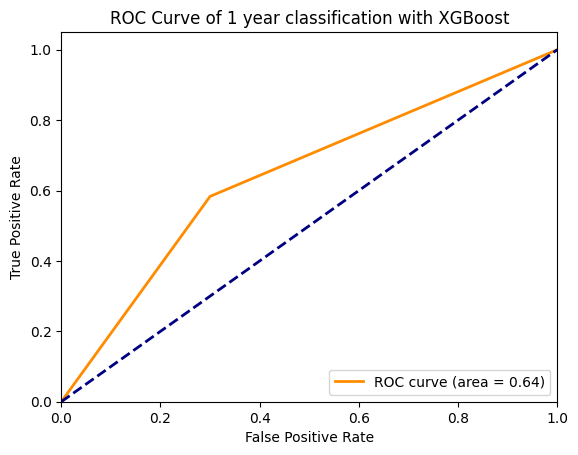

In [26]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, auc

# Define the list of thresholds
threshold = np.arange(0, 0.08, 0.001)

n = []
best_threshold = []
test_acc = []

classification_reports = []
fpr_global = []
tpr_global = []
thresholds_global = []
confusion_matrices = []

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10],
    'learning_rate': [1e-2, 1e-1, 1, 1e2, 1e3],
    'random_state': [42],
    'eval_metric' : [f1_score]
}
for thresh in threshold:
    
    # Select features using the threshold
    selection = SelectFromModel(XGBClassifier(), threshold=thresh).fit(X_train, y_train)
    select_X_train = selection.transform(X_train)
    
    # Train the model
    selection_model = XGBClassifier()
    grid_search = GridSearchCV(selection_model, param_grid, cv=5, scoring='f1', verbose=1)
    grid_search.fit(select_X_train, y_train)
    
    # Evaluate the model
    select_X_test = selection.transform(X_test)

    y_pred = grid_search.predict(select_X_test)
    predictions = [round(value, 3) for value in y_pred]
    accuracy = f1_score(y_test, predictions)
    
    print("Thresh=%.3f, n=%d, F1 Score: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    print("Best Performer:", grid_search.best_params_)
    best_threshold.append(thresh)
    n.append(select_X_train.shape[1])
    test_acc.append(accuracy)

    # Calculate and store the classification report
    report = classification_report(y_test, y_pred, digits=4)
    classification_reports.append(report)

    # Save ROC params
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    fpr_global.append(fpr)
    tpr_global.append(tpr)
    thresholds_global.append(thresholds)

    # Save confusion matrix
    cm = confusion_matrix(y_test, predictions)
    confusion_matrices.append(cm)

print("------------------------------------------")
print('RESULTS:')
best_acc_ind = np.argmax(test_acc)
best_acc = np.max(test_acc)
best_threshold = best_threshold[best_acc_ind]
best_n = n[best_acc_ind]
print("Thresh=%.3f, n=%d, F1 Score: %.2f%%" % (best_threshold,best_n, best_acc*100.0))

best_classification_report = classification_reports[best_acc_ind]
print(best_classification_report)
best_confusion_matrix = confusion_matrices[best_acc_ind]
print(best_confusion_matrix)

best_fpr = fpr_global[best_acc_ind]
best_tpr = tpr_global[best_acc_ind]
best_thresholds = thresholds_global[best_acc_ind]

# Calculate the AUC
roc_auc = auc(best_fpr, best_tpr)

plt.figure()
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of 1 year classification with XGBoost')
plt.legend(loc="lower right")
plt.show()

#### Do it with SVM

Fitting 5 folds for each of 30 candidates, totalling 150 fits
------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Iteration  1
Best Score: 0.5781338742393509
Thresh=0.000, n=108, F1 Score: 18.75%
Best Performer: {'C': 0.5, 'kernel': 'linear', 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Iteration  2
Best Score: 0.6107936507936509
Thresh=0.001, n=85, F1 Score: 14.29%
Best Performer: {'C': 0.1, 'kernel': 'linear', 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fits
------------------------------------------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Iteration  3
Best Score: 0.6042442442442442
Thresh=0.002, n=78, F1 Score: 33.33%
Best Performer: {'C': 2, 'kernel': 'linear', 'random_state': 42}
Fitting 5 folds for each of 30 candidates, totalling 150 fi

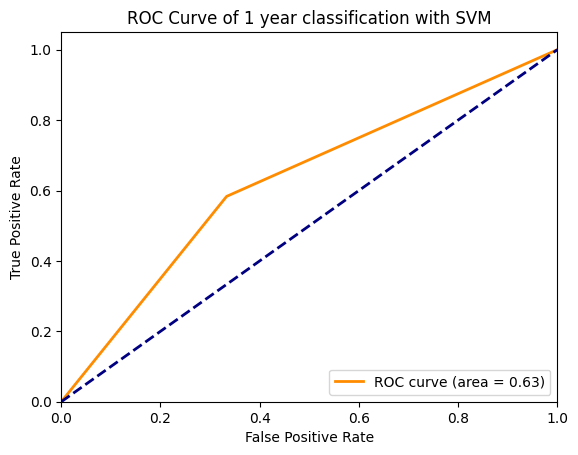

In [29]:
# Define the list of thresholds
threshold = np.arange(0, 0.08, 0.001)

n = []
best_threshold = []
test_acc = []
ind = 1 

classification_reports = []
fpr_global = []
tpr_global = []
thresholds_global = []
confusion_matrices = []
grid_search_results = []

param_grid_XGBoost = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10],
    'learning_rate': [1e-2, 1e-1, 1, 1e2, 1e3],
    'random_state': [42],
    'eval_metric' : [f1_score]
}

# SVM Classifier
model = svm.SVC()
param_grid = {'C': [0.1,0.5,1,2,5,10],
            'kernel': ['linear','rbf',],
            'random_state': [42]}

for thresh in threshold:
    
    # Select features using the threshold
    selection = SelectFromModel(XGBClassifier(), threshold=thresh).fit(X_train, y_train)
    select_X_train = selection.transform(X_train)
    
    # Train the model
    selection_model = XGBClassifier()
    grid_search = GridSearchCV(selection_model, param_grid_XGBoost, cv=5, scoring='f1', verbose=1)
    grid_search.fit(select_X_train, y_train)
    
    # Evaluate the model
    model = svm.SVC()
    print("------------------------------------------")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1)
    grid_search.fit(select_X_train, y_train)
    print("Iteration ", ind)
    best_score = grid_search.best_score_
    print("Best Score:", best_score)
    grid_search_results.append(grid_search)
    ind += 1

    # Evaluate the model
    select_X_test = selection.transform(X_test)
    # Perform prediction using the best parameters
    y_pred = grid_search.predict(select_X_test) 
    # Calculate the accuracy of the model
    accuracy = f1_score(y_test, y_pred)
    predictions = [round(value, 3) for value in y_pred]

    print("Thresh=%.3f, n=%d, F1 Score: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    print("Best Performer:", grid_search.best_params_)
    best_threshold.append(thresh)
    n.append(select_X_train.shape[1])
    test_acc.append(accuracy)

    # Calculate and store the classification report
    report = classification_report(y_test, y_pred, digits=4)
    classification_reports.append(report)

    # Save ROC params
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    fpr_global.append(fpr)
    tpr_global.append(tpr)
    thresholds_global.append(thresholds)

    # Save confusion matrix
    cm = confusion_matrix(y_test, predictions)
    confusion_matrices.append(cm)

print("------------------------------------------")
print('RESULTS:')
print("Iteration ", ind)
best_acc_ind = np.argmax(test_acc)
best_acc = np.max(test_acc)
best_threshold = best_threshold[best_acc_ind]
best_n = n[best_acc_ind]
print("Thresh=%.3f, n=%d, F1 Score: %.2f%%" % (best_threshold,best_n, best_acc*100.0))

best_classification_report = classification_reports[best_acc_ind]
print(best_classification_report)
best_confusion_matrix = confusion_matrices[best_acc_ind]
print(best_confusion_matrix)

best_fpr = fpr_global[best_acc_ind]
best_tpr = tpr_global[best_acc_ind]
best_thresholds = thresholds_global[best_acc_ind]

# Calculate the AUC
roc_auc = auc(best_fpr, best_tpr)

plt.figure()
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of 1 year classification with SVM')
plt.legend(loc="lower right")
plt.show()